In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install keras
!pip install tensorflow
!pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import cv2
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import normalize
import matplotlib.pyplot as plt
from scipy import ndimage as nd
from scipy import misc
from scipy.ndimage import laplace
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score,confusion_matrix

In [4]:
dataset = []
label = []

img_dir = './dataset/'

In [5]:
no_tumor_img = os.listdir(img_dir + 'no/')
for i, img_name in enumerate(no_tumor_img):
    if(img_name.split('.')[1] == 'jpg'):
        img=cv2.imread(img_dir+'no/'+img_name)
        img = Image.fromarray(img,'RGB')
        img=img.resize((128,128))
        img = nd.gaussian_filter(img,sigma = 1)
        img=laplace(img)
        dataset.append(np.array(img))
        label.append(0)

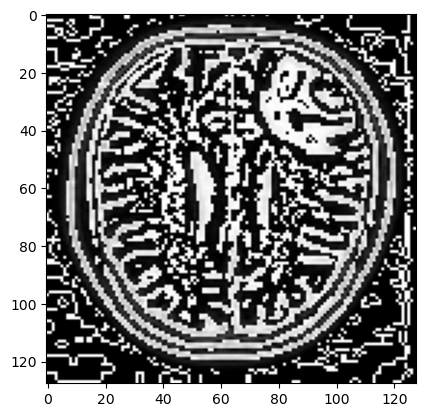

In [6]:
yes_tumor_img = os.listdir(img_dir + 'yes/')
for i, img_name in enumerate(yes_tumor_img):
    if(img_name.split('.')[1] == 'jpg'):
        img=cv2.imread(img_dir+'yes/'+img_name)
        img = Image.fromarray(img,'RGB')
        img=img.resize((128,128))
        img = nd.gaussian_filter(img,sigma = 1)
        img=laplace(img)
        plt.imshow(img)
        dataset.append(np.array(img))
        label.append(1)

In [7]:
dataset = np.array(dataset)
label = np.array(label)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(dataset,label,test_size=0.2,random_state=0)
y_train.shape
#x_train.shape

(2400,)

In [9]:
x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)

In [10]:
from sklearn.metrics import accuracy_score,confusion_matrix

# EfficientNetB0

In [11]:
# EfficientNetB0 Feature Vector
effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Feature Layer
effnet_layer = hub.KerasLayer(effnet_url,
                              trainable=False,
                              name="feature_extraction_layer")

# Create Sequential model
effnet_model = Sequential([
    effnet_layer,
    Dense(1, activation="sigmoid")
])

effnet_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Fit the model
# effnet_history = effnet_model.fit(x_train,y_train,
#                                   epochs=10,
#                                   steps_per_epoch=len((x_train,y_train)),
#                                   validation_data=(x_test,y_test),
#                                   validation_steps=len((x_test,y_test)))

effnet_history = effnet_model.fit(x_train,y_train,batch_size=16, verbose = 1, epochs = 10, validation_data=(x_test,y_test), shuffle=False)

Epoch 1/10



150/150 [==============================] - 46s 216ms/step - loss: 0.5802 - accuracy: 0.7108 - val_loss: 0.5486 - val_accuracy: 0.7233
Epoch 2/10
150/150 [==============================] - 28s 189ms/step - loss: 0.4644 - accuracy: 0.7979 - val_loss: 0.4889 - val_accuracy: 0.7500
Epoch 3/10
150/150 [==============================] - 32s 211ms/step - loss: 0.4144 - accuracy: 0.8271 - val_loss: 0.4527 - val_accuracy: 0.7867
Epoch 4/10
150/150 [==============================] - 28s 189ms/step - loss: 0.3817 - accuracy: 0.8462 - val_loss: 0.4257 - val_accuracy: 0.8150
Epoch 5/10
150/150 [==============================] - 28s 186ms/step - loss: 0.3576 - accuracy: 0.8587 - val_loss: 0.4040 - val_accuracy: 0.8317
Epoch 6/10
150/150 [==============================] - 29s 191ms/step - loss: 0.3385 - accuracy: 0.8675 - val_loss: 0.3859 - val_accuracy: 0.8400
Epoch 7/10
150/150 [==============================] - 29s 194ms/step - loss: 0.3228 - accuracy: 0.8779 - val_loss: 0.3704 - val_accuracy: 0.8

In [12]:
answer = effnet_model.predict(x_test)
answer = answer.flatten()

y_predNet = np.where(answer > 0.5, 1, 0)

print(confusion_matrix(y_test, y_predNet))

print(accuracy_score(y_test, y_predNet))

19/19 [==============================] - 12s 427ms/step
[[277  66]
 [ 17 240]]
0.8616666666666667


In [13]:
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """
    import matplotlib.pyplot as plt

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

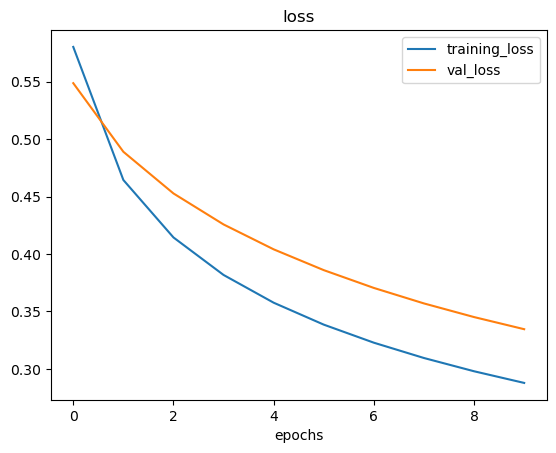

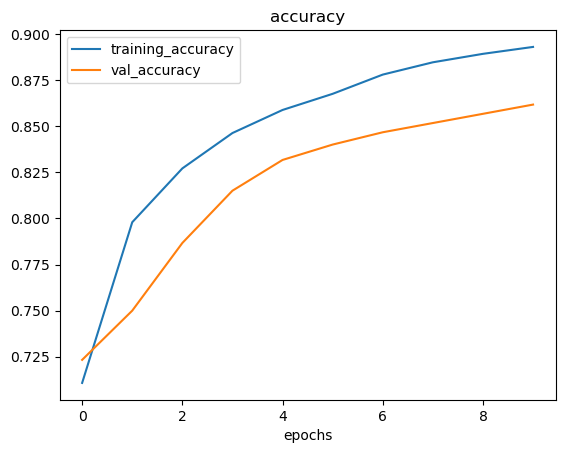

In [14]:
plot_curves(effnet_history)

In [15]:

import itertools

In [16]:
res = effnet_model.evaluate(x_test,y_test, verbose=0)
print(f"Accuracy on Evaluation: {res[1]*100:.2f}%\nLoss: {res[0]:.4f}")

Accuracy on Evaluation: 86.17%
Loss: 0.3345


In [17]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix , With out normalization')
        
    thres=cm.max()/2
    for i ,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment='center',color='white' if cm[i,j]> thres else 'black')
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Model accuracy (in %): 86.16666666666667
Confusion Matrix , With out normalization


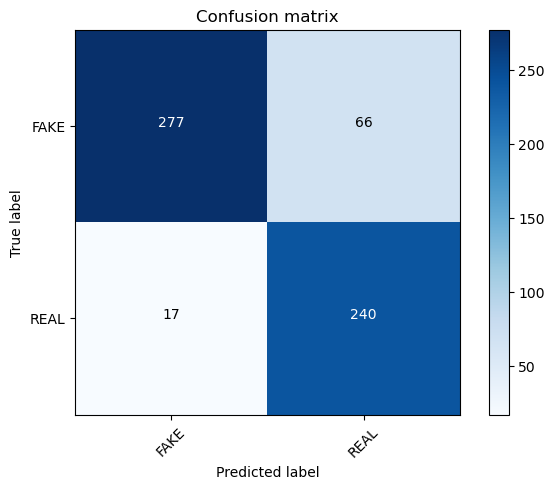

In [18]:
score=accuracy_score(y_test,y_predNet)
print("Model accuracy (in %):", score*100)
cm=confusion_matrix(y_test,y_predNet)
plot_confusion_matrix(cm,classes=['FAKE','REAL'])